In [1]:
import pandas as pd
import os

In [2]:
file_paths = {
    "VDJdb_beta": vdjdb_beta_read_path,
    "McPAS_beta": mcpastcr_beta_read_path,
    "IEDB_beta": iedb_beta_read_path,
    "pMTnet_beta": pmtnet_beta_read_path,
    "VDJdb_paired": vdjdb_paired_read_path,
    "McPAS_paired": mcpastcr_paired_read_path,
    "IEDB_paired": iedb_paired_read_path
}

NameError: name 'vdjdb_beta_read_path' is not defined

In [ ]:
import pandas as pd
import os

# Function to classify tasks based on TCR and epitope presence
def calculate_task(row, known_epitopes, known_tcr, paired=False):
    if paired:
        tra_cdr3 = str(row['TRA_CDR3']) if pd.notna(row['TRA_CDR3']) else ''
        trb_cdr3 = str(row['TRB_CDR3']) if pd.notna(row['TRB_CDR3']) else ''
        tcr = tra_cdr3 + '_' + trb_cdr3
    else:
        tcr = row['TRB_CDR3']
    
    epitope_exists = row['Epitope'] in known_epitopes
    cdr3_exists = tcr in known_tcr
    
    if epitope_exists and cdr3_exists:
        return 'TPP1'
    elif epitope_exists and not cdr3_exists:
        return 'TPP2'
    elif not epitope_exists and not cdr3_exists:
        return 'TPP3'
    elif not epitope_exists and cdr3_exists:
        return 'TPP4'
    raise Exception("Something seems wrong")

# Placeholder for the data
all_data = {}

# Load and prepare data
for file_name, path in file_paths.items():
    if os.path.exists(path):
        try:
            df = pd.read_csv(path, sep=None, engine="python")

            # Create tcr_key
            if "TRA_CDR3" in df.columns:
                paired = True
                df["tcr_key"] = df["TRA_CDR3"].astype(str) + '_' + df["TRB_CDR3"]
            else:
                paired = False
                df["tcr_key"] = df["TRB_CDR3"]

            all_data[file_name] = df
            print(f"{file_name} geladen mit {len(df)} Einträgen.")

        except Exception as e:
            print(f"Fehler beim Verarbeiten der Datei {file_name}: {e}")
    else:
        print(f"Datei nicht gefunden: {file_name}")

# Analyse: Classify TPP tasks
for test_file_name, test_df in all_data.items():
    # Define training data (excluding the current test set)
    train_df = pd.concat([data for name, data in all_data.items() if name != test_file_name]).drop_duplicates()

    seen_tcrs = set(train_df["tcr_key"])
    seen_epitopes = set(train_df["Epitope"])

    # Determine if it's a paired dataset
    paired = "TRA_CDR3" in test_df.columns

    # Apply classification
    test_df['task'] = test_df.apply(lambda row: calculate_task(row, seen_epitopes, seen_tcrs, paired=paired), axis=1)

    # Count TPP3 pairs
    tpp3_pairs = (test_df['task'] == 'TPP3').sum()

    # Print the results
    print(f"\n**Wenn {test_file_name} als Testset verwendet wird:**")
    print(f"  - TPP3-Paare im Testset: {tpp3_pairs}")
    print(f"  - Gesamt Test-Paare: {len(test_df)}")


In [ ]:
import pandas as pd
import os

# Function to classify TPP tasks based on TCR and epitope presence
def calculate_task(row, known_epitopes, known_tcr, paired=False):
    if paired:
        tra_cdr3 = str(row['TRA_CDR3']) if pd.notna(row['TRA_CDR3']) else ''
        trb_cdr3 = str(row['TRB_CDR3']) if pd.notna(row['TRB_CDR3']) else ''
        tcr = tra_cdr3 + '_' + trb_cdr3
    else:
        tcr = row['TRB_CDR3']
    
    epitope_exists = row['Epitope'] in known_epitopes
    cdr3_exists = tcr in known_tcr
    
    if epitope_exists and cdr3_exists:
        return 'TPP1'
    elif epitope_exists and not cdr3_exists:
        return 'TPP2'
    elif not epitope_exists and not cdr3_exists:
        return 'TPP3'
    elif not epitope_exists and cdr3_exists:
        return 'TPP4'
    raise Exception("Something seems wrong")


# Load train and validation data
train_file = f'{pipeline_data_splitted}/{precision}/beta/train.tsv'
validation_file = f'{pipeline_data_splitted}/{precision}/beta/validation.tsv'
test_file = f'{pipeline_data_splitted}/{precision}/beta/test.tsv'
vdjdb_test_file = vdjdb_beta_read_path  # Path to the VDJdb test dataset

df_train = pd.read_csv(train_file, sep='\t')
df_validation = pd.read_csv(validation_file, sep='\t')
df_test = pd.read_csv(test_file, sep='\t')

# Combine train and validation datasets
trainval_df = pd.concat([df_train, df_validation], ignore_index=True)

# Load VDJdb test data
vdjdb_df = pd.read_csv(vdjdb_test_file, sep='\t') #f'{pipeline_data_cleaned}/VDJdb/VDJdb_cleaned_data_beta.tsv'

# Create tcr_key and clean data
trainval_df["tcr_key"] = trainval_df["TRB_CDR3"].astype(str).str.strip()
trainval_df["Epitope"] = trainval_df["Epitope"].astype(str).str.strip()

vdjdb_df["tcr_key"] = vdjdb_df["TRB_CDR3"].astype(str).str.strip()
vdjdb_df["Epitope"] = vdjdb_df["Epitope"].astype(str).str.strip()

df_test["tcr_key"] = df_test["TRB_CDR3"].astype(str).str.strip()
df_test["Epitope"] = df_test["Epitope"].astype(str).str.strip()

# Generate lookup sets for fast comparison
seen_tcrs = set(trainval_df["tcr_key"])
seen_epitopes = set(trainval_df["Epitope"])

# Apply classification to the VDJdb dataset
vdjdb_df['task'] = vdjdb_df.apply(lambda row: calculate_task(row, seen_epitopes, seen_tcrs, paired=False), axis=1)

# Count TPP3 pairs
tpp3_pairs = (vdjdb_df['task'] == 'TPP3').sum()

# Print the results
print(f"\n**TPP Analysis for VDJdb with Train + Validation**")
print(f"  - TPP3-Paare im Testset: {tpp3_pairs}")
print(f"  - Gesamt Test-Paare: {len(vdjdb_df)}")


In [ ]:
# Original TPP3 Paare vor dem Hinzufügen negativer Daten
original_tpp3 = vdjdb_df[(vdjdb_df['task'] == 'TPP3')][["tcr_key", "Epitope"]]

# Prüfen, ob diese TPP3-Paare in den negativen Daten des Train/Validation-Sets auftauchen
negative_in_trainval = trainval_df[trainval_df['Binding'] == 0][["tcr_key", "Epitope"]]

# Vergleichen
tpp3_now_seen = original_tpp3.merge(negative_in_trainval, on=["tcr_key", "Epitope"], how="inner")

print(f"Anzahl der ursprünglichen TPP3-Paare, die jetzt in negativen Daten des Train/Validation-Sets vorkommen: {len(tpp3_now_seen)}")

# Zeige einige Beispiele
if not tpp3_now_seen.empty:
    print(tpp3_now_seen.head(10))
else:
    print("Keine der ursprünglichen TPP3-Paare wurden in den negativen Daten gefunden.")

# Prüfen, ob die ursprünglichen TPP3-Paare in den positiven Daten des Train/Validation-Sets enthalten sind
positive_in_trainval = trainval_df[trainval_df['Binding'] == 1][["tcr_key", "Epitope"]]

# Vergleich durchführen
tpp3_in_pos_trainval = original_tpp3.merge(positive_in_trainval, on=["tcr_key", "Epitope"], how="inner")

print(f"Anzahl der ursprünglichen TPP3-Paare, die jetzt in den positiven Train/Validation-Daten vorkommen: {len(tpp3_in_pos_trainval)}")

In [ ]:
# Paths to the concatenated files
concatenated_beta_file = f'{pipeline_data_concatenated}/{precision}/beta_concatenated.tsv'
vdjdb_test_file = vdjdb_beta_read_path  # Path to the original VDJdb data

# Load concatenated beta data
concatenated_beta_df = pd.read_csv(concatenated_beta_file, sep='\t')

# Load original VDJdb dataset
vdjdb_df = pd.read_csv(vdjdb_test_file, sep='\t')

# Create tcr_key and clean data
concatenated_beta_df["tcr_key"] = concatenated_beta_df["TRB_CDR3"].astype(str).str.strip()
concatenated_beta_df["Epitope"] = concatenated_beta_df["Epitope"].astype(str).str.strip()

vdjdb_df["tcr_key"] = vdjdb_df["TRB_CDR3"].astype(str).str.strip()
vdjdb_df["Epitope"] = vdjdb_df["Epitope"].astype(str).str.strip()

# Generate lookup sets from concatenated data
seen_tcrs = set(concatenated_beta_df["tcr_key"])
seen_epitopes = set(concatenated_beta_df["Epitope"])

# Apply classification to the VDJdb dataset
vdjdb_df['task'] = vdjdb_df.apply(lambda row: calculate_task(row, seen_epitopes, seen_tcrs, paired=False), axis=1)

# Count TPP3 pairs
tpp3_pairs = (vdjdb_df['task'] == 'TPP3').sum()

# Print the results
print(f"\n**TPP Analysis for VDJdb with Concatenated Beta Data**")
print(f"  - TPP3-Paare im Testset: {tpp3_pairs}")
print(f"  - Gesamt Test-Paare: {len(vdjdb_df)}")

In [ ]:
# Negative Daten aus Train/Validation
negative_in_trainval = trainval_df[trainval_df['Binding'] == 0][["tcr_key", "Epitope"]]
negative_in_test = df_test[df_test['Binding'] == 0][["tcr_key", "Epitope"]]

# Prüfen, ob VDJdb-TCRs in den negativen Daten vorkommen
tpp3_tcr_overlap = vdjdb_df[~vdjdb_df['tcr_key'].isin(seen_tcrs) & vdjdb_df['tcr_key'].isin(set(negative_in_trainval['tcr_key']))]
tpp3_tcr_overlap_test = vdjdb_df[~vdjdb_df['tcr_key'].isin(seen_tcrs) & vdjdb_df['tcr_key'].isin(set(negative_in_test['tcr_key']))]

# Prüfen, ob VDJdb-Epitope in den negativen Daten vorkommen
tpp3_epitope_overlap = vdjdb_df[~vdjdb_df['Epitope'].isin(seen_epitopes) & vdjdb_df['Epitope'].isin(set(negative_in_trainval['Epitope']))]
tpp3_epitope_overlap_test = vdjdb_df[~vdjdb_df['Epitope'].isin(seen_epitopes) & vdjdb_df['Epitope'].isin(set(negative_in_trainval['Epitope']))]

print(f"VDJdb TPP3-Paare, deren TCR jetzt in negativen Daten aus Train/Validation vorkommt: {len(tpp3_tcr_overlap)}")
print(f"VDJdb TPP3-Paare, deren Epitope jetzt in negativen Daten aus Train/Validation vorkommt: {len(tpp3_epitope_overlap)}")

In [ ]:
# Load VDJdb test data
vdjdb_df = pd.read_csv(vdjdb_test_file, sep='\t') #f'{pipeline_data_cleaned}/VDJdb/VDJdb_cleaned_data_beta.tsv'
vdjdb_df["tcr_key"] = vdjdb_df["TRB_CDR3"].astype(str).str.strip()
vdjdb_df["Epitope"] = vdjdb_df["Epitope"].astype(str).str.strip()
vdjdb_df['task'] = vdjdb_df.apply(lambda row: calculate_task(row, seen_epitopes, seen_tcrs, paired=False), axis=1)
# TPP3-Paare aus dem vdjdb File
original_tpp3 = vdjdb_df[vdjdb_df['task'] == 'TPP3'][["tcr_key", "Epitope"]]
# Prüfen, ob diese TPP3-Paare im finalen Testset noch vorhanden sind
tpp3_in_test = original_tpp3.merge(df_test, on=["tcr_key", "Epitope"], how="inner")
print(f"TPP3-Paare von cleaned data, die noch im finalen Testset vorhanden sind: {len(tpp3_in_test)}")

# Prüfen, welche TPP-Klasse die TPP3-Paare jetzt im finalen Testset haben
tpp3_in_test_with_task = original_tpp3.merge(df_test, on=["tcr_key", "Epitope"], how="inner")

# Zählen, wie viele der ursprünglichen TPP3-Paare jetzt welcher TPP-Klasse zugeordnet wurden
task_distribution = tpp3_in_test_with_task['task'].value_counts()

print(f"\n✅ TPP3-Paare von cleaned data, die noch im finalen Testset vorhanden sind: {len(tpp3_in_test_with_task)}")
print(f"🔄 Aktuelle TPP-Klassen dieser Paare im finalen Testset:")
print(task_distribution)

In [ ]:
# Prüfen, ob TCRs in negativen Daten des Train/Validation-Sets vorkommen
tcrs_in_negative_trainval = original_tpp3[original_tpp3['tcr_key'].isin(trainval_df[trainval_df['Binding'] == 0]['tcr_key'])]

# Prüfen, ob Epitope in negativen Daten des Train/Validation-Sets vorkommen
epitopes_in_negative_trainval = original_tpp3[original_tpp3['Epitope'].isin(trainval_df[trainval_df['Binding'] == 0]['Epitope'])]

print(f"⚠️ Anzahl TPP3-Paare, deren TCRs in den negativen Train/Validation-Daten vorkommen: {len(tcrs_in_negative_trainval)}")
print(f"⚠️ Anzahl TPP3-Paare, deren Epitope in den negativen Train/Validation-Daten vorkommen: {len(epitopes_in_negative_trainval)}")

# Prüfen, ob TCRs in den positiven Daten vorkommen
tcrs_in_positive_trainval = original_tpp3[original_tpp3['tcr_key'].isin(trainval_df[trainval_df['Binding'] == 1]['tcr_key'])]

# Prüfen, ob Epitope in den positiven Daten vorkommen
epitopes_in_positive_trainval = original_tpp3[original_tpp3['Epitope'].isin(trainval_df[trainval_df['Binding'] == 1]['Epitope'])]

print(f"✅ Anzahl TPP3-Paare, deren TCRs in den positiven Train/Validation-Daten vorkommen: {len(tcrs_in_positive_trainval)}")
print(f"✅ Anzahl TPP3-Paare, deren Epitope in den positiven Train/Validation-Daten vorkommen: {len(epitopes_in_positive_trainval)}")


In [3]:
pipeline_data = '../../../../data'
pipeline_data_plain = f'{pipeline_data}/plain_datasets'
pipeline_data_cleaned = f'{pipeline_data}/cleaned_datasets'
pipeline_data_concatenated = f'{pipeline_data}/concatenated_datasets'
pipeline_data_splitted = f'{pipeline_data}/splitted_datasets'
pipeline_data_temp_bucket = f'{pipeline_data}/temp'
precision = "allele"

import pandas as pd

train_file = f'{pipeline_data_splitted}/{precision}/beta/new/train.tsv'
validation_file = f'{pipeline_data_splitted}/{precision}/beta/new/validation.tsv'
test_file = f'{pipeline_data_splitted}/{precision}/beta/new/test.tsv'

# Helper-Funktion
def count_unique_epitopes(file_path, split_name):
    df = pd.read_csv(file_path, sep='\t')
    df['split'] = split_name
    return df.groupby('Binding')['Epitope'].nunique().reset_index(name='unique_epitopes').assign(split=split_name)

# Ergebnisse sammeln
results = pd.concat([
    count_unique_epitopes(train_file, 'train'),
    count_unique_epitopes(validation_file, 'val'),
    count_unique_epitopes(test_file, 'test')
])

# Umstrukturieren für bessere Übersicht
summary = results.pivot(index='split', columns='Binding', values='unique_epitopes').rename(columns={0: 'non-binding', 1: 'binding'}).fillna(0).astype(int)

print(summary)


Binding  non-binding  binding
split                        
test             650      293
train            713      981
val              645     1450


In [4]:
# Definierte Pfade für alle vier Kategorien
datasets = {
    "beta_allele": {
        "train": f'{pipeline_data_splitted}/{precision}/beta/train.tsv',
        "test": f'{pipeline_data_splitted}/{precision}/beta/test.tsv',
        "validation": f'{pipeline_data_splitted}/{precision}/beta/validation.tsv'
    }
}

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

# Analyse-Funktionen (ergänzt mit Visualisierung & weiteren Checks)

def load_datasets(paths):
    dfs = {}
    for split, path in paths.items():
        if os.path.exists(path):
            dfs[split] = pd.read_csv(path, sep="\t")
        else:
            dfs[split] = None
    return dfs

def dataset_overview(df, name):
    print(f"\n--- {name.upper()} OVERVIEW ---")
    print(f"Total rows: {len(df)}")
    print("Unique TCRs:", df["TRB_CDR3"].nunique())
    print("Unique Epitopes:", df["Epitope"].nunique())
    print("Unique (TCR, Epitope) pairs:", df[["TRB_CDR3", "Epitope"]].drop_duplicates().shape[0])
    print("Binding distribution:\n", df["Binding"].value_counts(normalize=True))

def check_duplicates_and_inconsistencies(df, name):
    print(f"\n--- {name.upper()} DUPLICATE & INCONSISTENCY CHECK ---")
    exact_duplicates = df.duplicated(subset=["TRB_CDR3", "Epitope", "Binding"]).sum()
    print(f"Exact duplicates: {exact_duplicates}")

    inconsistent_labels = df.groupby(["TRB_CDR3", "Epitope"])["Binding"].nunique()
    print("Inconsistent (TCR, Epitope) label pairs (0 and 1):", (inconsistent_labels == 2).sum())

def check_overlap(df1, df2, name1, name2):
    set1 = set(zip(df1["TRB_CDR3"], df1["Epitope"]))
    set2 = set(zip(df2["TRB_CDR3"], df2["Epitope"]))
    overlap = set1 & set2
    print(f"\n--- OVERLAP BETWEEN {name1.upper()} AND {name2.upper()} ---")
    print(f"Shared (TCR, Epitope) pairs: {len(overlap)}")

def epitope_binding_distribution(df, name):
    print(f"\n--- {name.upper()} EPITOPE-WISE BINDING DISTRIBUTION ---")
    epitope_dist = df.groupby("Epitope")["Binding"].value_counts(normalize=True).unstack().fillna(0)
    print(epitope_dist.head())

    # Visualisierung
    plt.figure(figsize=(10, 6))
    sns.heatmap(epitope_dist, annot=True, fmt=".2f", cmap="Blues", cbar=True)
    plt.title(f"Binding Distribution per Epitope ({name})")
    plt.ylabel("Epitope")
    plt.xlabel("Binding Label")
    plt.tight_layout()
    plt.show()

def plot_epitope_counts(df, name):
    counts = df["Epitope"].value_counts()
    plt.figure(figsize=(12, 6))
    sns.barplot(x=counts.index, y=counts.values)
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Epitope Occurrences in {name}")
    plt.ylabel("Count")
    plt.xlabel("Epitope")
    plt.tight_layout()
    plt.show()

def plot_tcr_frequencies(df, name):
    tcr_counts = df["TRB_CDR3"].value_counts()
    top_tcrs = tcr_counts.head(20)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_tcrs.index, y=top_tcrs.values)
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Top 20 Most Frequent TCRs in {name}")
    plt.ylabel("Count")
    plt.xlabel("TCR Sequence")
    plt.tight_layout()
    plt.show()


datasets = {
    "beta_allele": {
        "train": f'{pipeline_data_splitted}/{precision}/beta/train.tsv',
        "test": f'{pipeline_data_splitted}/{precision}/beta/test.tsv',
        "validation": f'{pipeline_data_splitted}/{precision}/beta/validation.tsv'
    }
}

data = {key: load_datasets(paths) for key, paths in datasets.items()}

for dataset_name, splits in data.items():
    train, val, test = splits["train"], splits["validation"], splits["test"]

    if train is not None:
        dataset_overview(train, f"{dataset_name} - train")
        check_duplicates_and_inconsistencies(train, f"{dataset_name} - train")
        #epitope_binding_distribution(train, f"{dataset_name} - train")
        #plot_epitope_counts(train, f"{dataset_name} - train")
        #plot_tcr_frequencies(train, f"{dataset_name} - train")

    if val is not None:
        dataset_overview(val, f"{dataset_name} - validation")
        check_duplicates_and_inconsistencies(val, f"{dataset_name} - validation")
        #epitope_binding_distribution(val, f"{dataset_name} - validation")
        #plot_epitope_counts(val, f"{dataset_name} - validation")
        #plot_tcr_frequencies(val, f"{dataset_name} - validation")

    if test is not None:
        dataset_overview(test, f"{dataset_name} - test")
        check_duplicates_and_inconsistencies(test, f"{dataset_name} - test")
        #epitope_binding_distribution(test, f"{dataset_name} - test")
        #plot_epitope_counts(test, f"{dataset_name} - test")
        #plot_tcr_frequencies(test, f"{dataset_name} - test")

    if train is not None and test is not None:
        check_overlap(train, test, "train", "test")
    if train is not None and val is not None:
        check_overlap(train, val, "train", "validation")
    if val is not None and test is not None:
        check_overlap(val, test, "validation", "test")



--- BETA_ALLELE - TRAIN OVERVIEW ---
Total rows: 840756
Unique TCRs: 186829
Unique Epitopes: 1222
Unique (TCR, Epitope) pairs: 488591
Binding distribution:
 Binding
0    0.833333
1    0.166667
Name: proportion, dtype: float64

--- BETA_ALLELE - TRAIN DUPLICATE & INCONSISTENCY CHECK ---
Exact duplicates: 352165
Inconsistent (TCR, Epitope) label pairs (0 and 1): 0

--- BETA_ALLELE - VALIDATION OVERVIEW ---
Total rows: 210192
Unique TCRs: 81391
Unique Epitopes: 1515
Unique (TCR, Epitope) pairs: 147486
Binding distribution:
 Binding
0    0.833333
1    0.166667
Name: proportion, dtype: float64

--- BETA_ALLELE - VALIDATION DUPLICATE & INCONSISTENCY CHECK ---
Exact duplicates: 62605
Inconsistent (TCR, Epitope) label pairs (0 and 1): 101

--- BETA_ALLELE - TEST OVERVIEW ---
Total rows: 53400
Unique TCRs: 34479
Unique Epitopes: 724
Unique (TCR, Epitope) pairs: 52266
Binding distribution:
 Binding
0    0.833333
1    0.166667
Name: proportion, dtype: float64

--- BETA_ALLELE - TEST DUPLICATE & 

<Figure size 1000x1500 with 0 Axes>

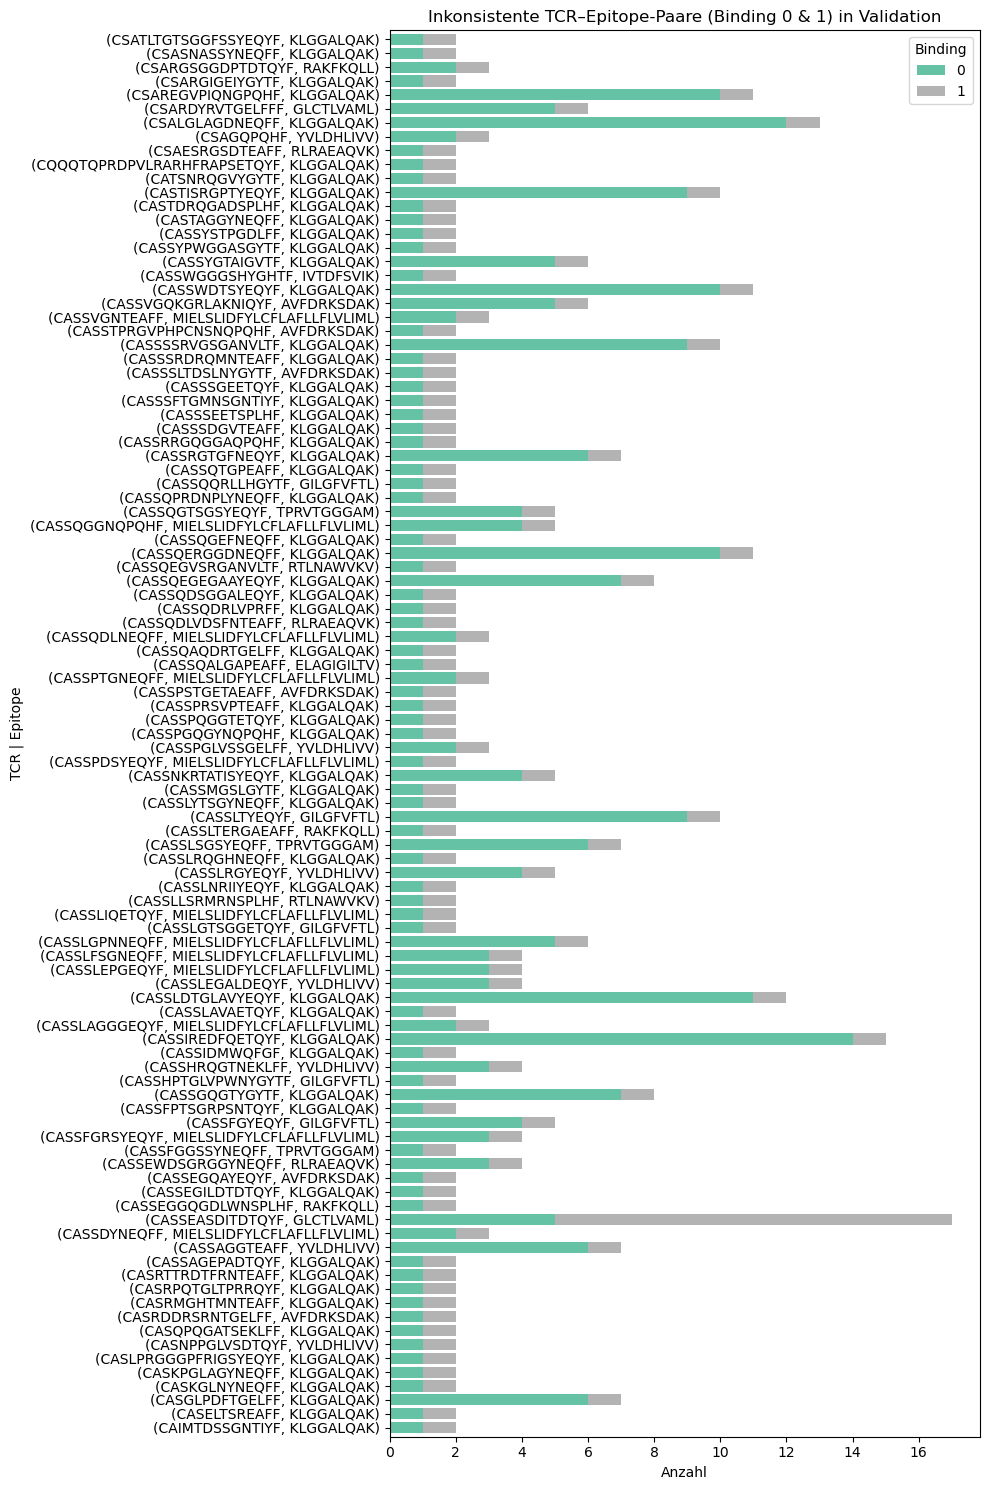

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Pfad zur validation-Datei (basierend auf deiner Struktur)
val_path = f'{pipeline_data_splitted}/{precision}/beta/validation.tsv'

# Daten laden
df_val = pd.read_csv(val_path, sep="\t")

# Inkonsistente Paare extrahieren
inconsistent = df_val.groupby(["TRB_CDR3", "Epitope"])["Binding"].nunique()
conflicting_pairs = inconsistent[inconsistent == 2].index
conflict_df = df_val.set_index(["TRB_CDR3", "Epitope"]).loc[conflicting_pairs].reset_index()

# Zählen wie oft jede Kombination mit 0 und 1 gelabelt wurde
conflict_counts = conflict_df.groupby(["TRB_CDR3", "Epitope"])["Binding"].value_counts().unstack().fillna(0)

# Plot erstellen
plt.figure(figsize=(10, min(15, len(conflict_counts) * 0.3)))  # Dynamische Höhe
conflict_counts.plot(kind="barh", stacked=True, figsize=(10, min(15, len(conflict_counts) * 0.3)), width=0.8, colormap="Set2")
plt.title("Inkonsistente TCR–Epitope-Paare (Binding 0 & 1) in Validation")
plt.xlabel("Anzahl")
plt.ylabel("TCR | Epitope")
plt.tight_layout()
plt.show()


In [5]:
# Analyse-Funktion
def analyze_binding_distribution(file_path):
    df = pd.read_csv(file_path, sep='\t')

    # Spaltennamen vereinheitlichen
    df.columns = [col.lower() for col in df.columns]

    if 'binding' not in df.columns or 'task' not in df.columns:
        raise ValueError(f"'binding' oder 'task' Spalte fehlt in {file_path}")

    # Gruppieren nach task und binding
    stats = df.groupby(['task', 'binding']).size().unstack(fill_value=0)

    # Spalten konsistent benennen (wenn z.B. nur 0 oder nur 1 vorkommt)
    if 0 in stats.columns and 1 in stats.columns:
        stats.columns = ['Non-Binder', 'Binder']
    elif 0 in stats.columns:
        stats['Binder'] = 0
        stats.columns = ['Non-Binder', 'Binder']
    elif 1 in stats.columns:
        stats['Non-Binder'] = 0
        stats.columns = ['Binder', 'Non-Binder']
    else:
        raise ValueError("Keine Binder/Non-Binder-Werte gefunden")

    # Berechnungen
    stats['Total'] = stats.sum(axis=1)
    stats['Binder %'] = (stats['Binder'] / stats['Total'] * 100).round(2)
    stats['Non-Binder %'] = (stats['Non-Binder'] / stats['Total'] * 100).round(2)

    return stats

# Alle Splits durchgehen
for dataset_name, splits in datasets.items():
    print(f"\n### Dataset: {dataset_name} ###")
    for split_name, path in splits.items():
        if os.path.exists(path):
            print(f"\n--- {split_name.upper()} ---")
            stats = analyze_binding_distribution(path)
            print(stats)
        else:
            print(f"{split_name} not found: {path}")


### Dataset: beta_allele ###

--- TEST ---
      Non-Binder  Binder  Total  Binder %  Non-Binder %
task                                                   
TPP1       41276    1059  42335      2.50         97.50
TPP2        3135    7728  10863     71.14         28.86
TPP3          10      88     98     89.80         10.20
TPP4          79      25    104     24.04         75.96

--- VALIDATION ---
      Non-Binder  Binder   Total  Binder %  Non-Binder %
task                                                    
TPP1      170206   18291  188497      9.70         90.30
TPP2        4634   15207   19841     76.64         23.36
TPP3          36    1509    1545     97.67          2.33
TPP4         284      25     309      8.09         91.91


In [ ]:
import pandas as pd

# Beispielpfad (ersetze durch deine Variable bei Bedarf)
test_path = datasets["beta_allele"]["test"]

# Lade das Test-TSV
df = pd.read_csv(test_path, sep='\t')

# Wieviele Zeilen hat die Datei insgesamt?
print(f"Anzahl Zeilen im Testset: {len(df)}")

# Duplikate anhand von TCR + Epitope + Binding (exakt gleiches Beispiel)
duplicates = df[df.duplicated(subset=["TRB_CDR3", "Epitope", "Binding"], keep=False)]

# Ausgabe: alle Duplikate
print(f"\nGesamtanzahl an Duplikaten: {len(duplicates)}")

# Gruppiert nach Bindungsklasse
dup_counts = duplicates.groupby("Binding").size()
print("\nAnzahl Duplikate pro Binding-Klasse:")
print(dup_counts)

# Optional: doppelte Kombinationen anzeigen
#print("\nBeispielhafte Duplikate:")
#print(duplicates.sort_values(by=["TRB_CDR3", "Epitope"]).head(10))


In [43]:
# Definierte Pfade für alle vier Kategorien
datasets = {
    "beta_allele": {
        "test": f'{pipeline_data_splitted}/{precision}/beta/test.tsv',
        "validation": f'{pipeline_data_splitted}/{precision}/beta/validation.tsv'
    }
}

In [44]:
# Analyse-Funktion
def analyze_binding_distribution(file_path):
    df = pd.read_csv(file_path, sep='\t')

    # Spaltennamen vereinheitlichen
    df.columns = [col.lower() for col in df.columns]

    if 'binding' not in df.columns or 'task' not in df.columns:
        raise ValueError(f"'binding' oder 'task' Spalte fehlt in {file_path}")

    # Gruppieren nach task und binding
    stats = df.groupby(['task', 'binding']).size().unstack(fill_value=0)

    # Spalten konsistent benennen (wenn z.B. nur 0 oder nur 1 vorkommt)
    if 0 in stats.columns and 1 in stats.columns:
        stats.columns = ['Non-Binder', 'Binder']
    elif 0 in stats.columns:
        stats['Binder'] = 0
        stats.columns = ['Non-Binder', 'Binder']
    elif 1 in stats.columns:
        stats['Non-Binder'] = 0
        stats.columns = ['Binder', 'Non-Binder']
    else:
        raise ValueError("Keine Binder/Non-Binder-Werte gefunden")

    # Berechnungen
    stats['Total'] = stats.sum(axis=1)
    stats['Binder %'] = (stats['Binder'] / stats['Total'] * 100).round(2)
    stats['Non-Binder %'] = (stats['Non-Binder'] / stats['Total'] * 100).round(2)

    return stats

# Alle Splits durchgehen
for dataset_name, splits in datasets.items():
    print(f"\n### Dataset: {dataset_name} ###")
    for split_name, path in splits.items():
        if os.path.exists(path):
            print(f"\n--- {split_name.upper()} ---")
            stats = analyze_binding_distribution(path)
            print(stats)
        else:
            print(f"{split_name} not found: {path}")


### Dataset: beta_allele ###

--- TEST ---
      Non-Binder  Binder  Total  Binder %  Non-Binder %
task                                                   
TPP1       44422    1059  45481      2.33         97.67
TPP2          68    7728   7796     99.13          0.87
TPP3           0      88     88    100.00          0.00
TPP4          10      25     35     71.43         28.57

--- VALIDATION ---
      Non-Binder  Binder   Total  Binder %  Non-Binder %
task                                                    
TPP1      170206   18291  188497      9.70         90.30
TPP2        4634   15207   19841     76.64         23.36
TPP3          36    1509    1545     97.67          2.33
TPP4         284      25     309      8.09         91.91


In [49]:
# Definierte Pfade für alle vier Kategorien
datasets = {
    "beta_allele": {
        "train": f'{pipeline_data_splitted}/{precision}/beta/new/train.tsv',
        "test": f'{pipeline_data_splitted}/{precision}/beta/new/test.tsv',
        "validation": f'{pipeline_data_splitted}/{precision}/beta/new/validation.tsv'
    }
}

In [47]:
# Analyse-Funktion
def analyze_binding_distribution(file_path):
    df = pd.read_csv(file_path, sep='\t')

    # Spaltennamen vereinheitlichen
    df.columns = [col.lower() for col in df.columns]

    if 'binding' not in df.columns or 'task' not in df.columns:
        raise ValueError(f"'binding' oder 'task' Spalte fehlt in {file_path}")

    # Gruppieren nach task und binding
    stats = df.groupby(['task', 'binding']).size().unstack(fill_value=0)

    # Spalten konsistent benennen (wenn z.B. nur 0 oder nur 1 vorkommt)
    if 0 in stats.columns and 1 in stats.columns:
        stats.columns = ['Non-Binder', 'Binder']
    elif 0 in stats.columns:
        stats['Binder'] = 0
        stats.columns = ['Non-Binder', 'Binder']
    elif 1 in stats.columns:
        stats['Non-Binder'] = 0
        stats.columns = ['Binder', 'Non-Binder']
    else:
        raise ValueError("Keine Binder/Non-Binder-Werte gefunden")

    # Berechnungen
    stats['Total'] = stats.sum(axis=1)
    stats['Binder %'] = (stats['Binder'] / stats['Total'] * 100).round(2)
    stats['Non-Binder %'] = (stats['Non-Binder'] / stats['Total'] * 100).round(2)

    return stats

# Alle Splits durchgehen
for dataset_name, splits in datasets.items():
    print(f"\n### Dataset: {dataset_name} ###")
    for split_name, path in splits.items():
        if os.path.exists(path):
            print(f"\n--- {split_name.upper()} ---")
            stats = analyze_binding_distribution(path)
            print(stats)
        else:
            print(f"{split_name} not found: {path}")


### Dataset: beta_allele ###

--- TEST ---
      Non-Binder  Binder  Total  Binder %  Non-Binder %
task                                                   
TPP1       41276    1059  42335      2.50         97.50
TPP2        3135    7728  10863     71.14         28.86
TPP3          10      88     98     89.80         10.20
TPP4          79      25    104     24.04         75.96

--- VALIDATION ---
      Non-Binder  Binder   Total  Binder %  Non-Binder %
task                                                    
TPP1      170206   18291  188497      9.70         90.30
TPP2        4634   15207   19841     76.64         23.36
TPP3          36    1509    1545     97.67          2.33
TPP4         284      25     309      8.09         91.91


In [6]:
import pandas as pd

# Lade die Daten
train_data = pd.read_csv(datasets["beta_allele"]["train"], sep="\t")
test_data = pd.read_csv(datasets["beta_allele"]["test"], sep="\t")

# Vergleiche MHC-Verteilungen (Top 10 häufigste MHCs, anteilig)
print("\nTop 10 MHCs im TRAINING:")
print(train_data["MHC"].value_counts(normalize=True).head(10))

print("\nTop 10 MHCs im TEST:")
print(test_data["MHC"].value_counts(normalize=True).head(10))

print(train_data["MHC"].value_counts().head(10))
print(test_data["MHC"].value_counts().head(10))




Top 10 MHCs im TRAINING:
MHC
HLA-A*02:01    0.654873
HLA-B*07:02    0.080040
HLA-A*24:02    0.051066
HLA-A*03:01    0.047830
HLA-A*01:01    0.040218
HLA-B*08:01    0.038804
HLA-A*11:01    0.032549
HLA-A*02       0.027665
HLA-B*35:01    0.013045
HLA-B*07       0.009232
Name: proportion, dtype: float64

Top 10 MHCs im TEST:
MHC
HLA-A*02:01    0.484202
HLA-A*03:01    0.109405
HLA-B*07:02    0.088974
HLA-A*24:02    0.059859
HLA-A*02       0.053385
HLA-A*11:01    0.051407
HLA-B*08:01    0.049895
HLA-A*01:01    0.048015
HLA-B*35:01    0.015837
HLA-B*08       0.005796
Name: proportion, dtype: float64
MHC
HLA-A*02:01    413216
HLA-B*07:02     50504
HLA-A*24:02     32222
HLA-A*03:01     30180
HLA-A*01:01     25377
HLA-B*08:01     24485
HLA-A*11:01     20538
HLA-A*02        17456
HLA-B*35:01      8231
HLA-B*07         5825
Name: count, dtype: int64
MHC
HLA-A*02:01    24979
HLA-A*03:01     5644
HLA-B*07:02     4590
HLA-A*24:02     3088
HLA-A*02        2754
HLA-A*11:01     2652
HLA-B*08:01     25

In [16]:
# Zusätzliche Analyse für einzigartige Epitope
unique_epitopes = {}

for dataset_name, paths in datasets.items():
    train_df = pd.read_csv(paths["train"], sep='\t')
    test_df = pd.read_csv(paths["test"], sep='\t')
    validation_df = pd.read_csv(paths["validation"], sep='\t')
    
    # Extrahieren einzigartiger Epitope
    train_unique = set(train_df["Epitope"].unique())
    test_unique = set(test_df["Epitope"].unique())
    validation_unique = set(validation_df["Epitope"].unique())
    
    # Gesamtanzahl einzigartiger Epitope
    all_unique = train_unique | test_unique | validation_unique  # Vereinigung der Sets

    # Ergebnisse speichern
    unique_epitopes[dataset_name] = {
        "Train_Unique": len(train_unique),
        "Test_Unique": len(test_unique),
        "Validation_Unique": len(validation_unique),
        "Total_Unique": len(all_unique),
        "Train_Epitopes": train_unique,
        "Test_Epitopes": test_unique,
        "Validation_Epitopes": validation_unique
    }

# Ergebnisse anzeigen
for dataset, epitopes in unique_epitopes.items():
    print(f'--- {dataset.replace("_", " ").title()} ---')
    print(f'Anzahl einzigartiger Epitope im Trainingsdatensatz: {epitopes["Train_Unique"]}')
    print(f'Anzahl einzigartiger Epitope im Testdatensatz: {epitopes["Test_Unique"]}')
    print(f'Anzahl einzigartiger Epitope im Validierungsdatensatz: {epitopes["Validation_Unique"]}')
    print(f'Gesamtanzahl einzigartiger Epitope (Train + Test + Validation): {epitopes["Total_Unique"]}\n')


--- Beta Allele ---
Anzahl einzigartiger Epitope im Trainingsdatensatz: 988
Anzahl einzigartiger Epitope im Testdatensatz: 878
Anzahl einzigartiger Epitope im Validierungsdatensatz: 1462
Gesamtanzahl einzigartiger Epitope (Train + Test + Validation): 1896



In [50]:
# Anzahl der einzigartigen Epitope pro Binding und pro Datei
unique_epitopes_count = {}

for dataset, paths in datasets.items():
    train_df = pd.read_csv(paths["train"], sep='\t')
    test_df = pd.read_csv(paths["test"], sep='\t')
    validation_df = pd.read_csv(paths["validation"], sep='\t')
    
    # Einzigartige Epitope für Binding=0 und Binding=1
    train_unique = {
        0: len(set(train_df[train_df['Binding'] == 0]['Epitope'])),
        1: len(set(train_df[train_df['Binding'] == 1]['Epitope']))
    }
    test_unique = {
        0: len(set(test_df[test_df['Binding'] == 0]['Epitope'])),
        1: len(set(test_df[test_df['Binding'] == 1]['Epitope']))
    }
    validation_unique = {
        0: len(set(validation_df[validation_df['Binding'] == 0]['Epitope'])),
        1: len(set(validation_df[validation_df['Binding'] == 1]['Epitope']))
    }
    
    # Ergebnisse speichern
    unique_epitopes_count[dataset] = {
        "Train_Binding_0": train_unique[0],
        "Train_Binding_1": train_unique[1],
        "Test_Binding_0": test_unique[0],
        "Test_Binding_1": test_unique[1],
        "Validation_Binding_0": validation_unique[0],
        "Validation_Binding_1": validation_unique[1]
    }

# Ergebnisse ausgeben
for dataset, counts in unique_epitopes_count.items():
    print(f'--- {dataset.replace("_", " ").title()} Unique Epitope Counts ---')
    print(f'Train (Binding=0): {counts["Train_Binding_0"]}, Train (Binding=1): {counts["Train_Binding_1"]}')
    print(f'Test (Binding=0): {counts["Test_Binding_0"]}, Test (Binding=1): {counts["Test_Binding_1"]}')
    print(f'Validation (Binding=0): {counts["Validation_Binding_0"]}, Validation (Binding=1): {counts["Validation_Binding_1"]}\n')


--- Beta Allele Unique Epitope Counts ---
Train (Binding=0): 713, Train (Binding=1): 981
Test (Binding=0): 650, Test (Binding=1): 293
Validation (Binding=0): 645, Validation (Binding=1): 1450



In [51]:
import pandas as pd

train_file = f'{pipeline_data_splitted}/{precision}/beta/new/train.tsv'
validation_file = f'{pipeline_data_splitted}/{precision}/beta/new/validation.tsv'
test_file = f'{pipeline_data_splitted}/{precision}/beta/new/test.tsv'

# Dateien einlesen
train_df = pd.read_csv(train_file, sep='\t')
val_df = pd.read_csv(validation_file, sep='\t')
test_df = pd.read_csv(test_file, sep='\t')

# Funktion zur Ausgabe der Verteilung
def show_binding_distribution(df, name):
    counts = df['Binding'].value_counts().sort_index()
    total = counts.sum()
    print(f'--- {name} ---')
    for b in counts.index:
        percentage = (counts[b] / total) * 100
        print(f'Binding = {b}: {counts[b]} Beispiele ({percentage:.2f}%)')
    print(f'Total: {total} Beispiele\n')

# Ausgabe
show_binding_distribution(train_df, 'Train')
show_binding_distribution(val_df, 'Validation')
show_binding_distribution(test_df, 'Test')

--- Train ---
Binding = 0: 700630 Beispiele (83.33%)
Binding = 1: 140126 Beispiele (16.67%)
Total: 840756 Beispiele

--- Validation ---
Binding = 0: 175160 Beispiele (83.33%)
Binding = 1: 35032 Beispiele (16.67%)
Total: 210192 Beispiele

--- Test ---
Binding = 0: 44500 Beispiele (83.33%)
Binding = 1: 8900 Beispiele (16.67%)
Total: 53400 Beispiele



In [52]:
import pandas as pd

# File paths
train_path = '../../../../data/splitted_datasets/allele/beta/new/train.tsv'
valid_path = '../../../../data/splitted_datasets/allele/beta/new/validation.tsv'
test_path  = '../../../../data/splitted_datasets/allele/beta/new/test.tsv'

# Load datasets
train_df = pd.read_csv(train_path, sep='\t')
valid_df = pd.read_csv(valid_path, sep='\t')
test_df  = pd.read_csv(test_path, sep='\t')

# Relevante Spalten
target_columns = ['Epitope', 'TRB_CDR3']

# Erzeuge Sets von Paaren aus Train und Validation
train_pairs = set(map(tuple, train_df[target_columns].values))
valid_pairs = set(map(tuple, valid_df[target_columns].values))

# Kombiniere Train & Val Paare
combined_pairs = train_pairs.union(valid_pairs)

# Erzeuge Pair-Spalte im Test-Set
test_df['Pair'] = test_df[target_columns].apply(tuple, axis=1)

# Filtere Testzeilen, deren Paare in Train/Val vorkommen
matching_test_df = test_df[test_df['Pair'].isin(combined_pairs)]

# Ausgabe
print(f"Anzahl Matching Rows im Test-Set (kommen auch in Train/Validation vor): {len(matching_test_df)}")
print("Verteilung nach Binding:")
print(matching_test_df['Binding'].value_counts())

Anzahl Matching Rows im Test-Set (kommen auch in Train/Validation vor): 0
Verteilung nach Binding:
Series([], Name: count, dtype: int64)


In [53]:
# Definierte Pfade für alle vier Kategorien
datasets = {
    "beta_allele": {
        "train": f'{pipeline_data_splitted}/{precision}/beta/train.tsv',
        "test": f'{pipeline_data_splitted}/{precision}/beta/test.tsv',
        "validation": f'{pipeline_data_splitted}/{precision}/beta/validation.tsv'
    }
}

In [54]:
import pandas as pd

for dataset_name, paths in datasets.items():
    print(f"\n📂 Dataset: {dataset_name.upper()}")
    
    for split_name, path in paths.items():
        try:
            df = pd.read_csv(path, sep='\t')
            print(f"\n📄 {split_name.upper()} ({len(df)} Zeilen)")

            if 'source' in df.columns:
                source_counts = df['source'].value_counts(dropna=False)
                source_percent = df['source'].value_counts(normalize=True, dropna=False) * 100

                print("🔢 Source-Verteilung:")
                for src in source_counts.index:
                    count = source_counts[src]
                    perc = source_percent[src]
                    print(f"  - {src}: {count} ({perc:.2f}%)")
            else:
                print("⚠️ Spalte 'source' nicht vorhanden.")

        except FileNotFoundError:
            print(f"❌ Datei nicht gefunden: {path}")
        except Exception as e:
            print(f"❗ Fehler beim Lesen von {path}: {e}")



📂 Dataset: BETA_ALLELE

📄 TRAIN (840756 Zeilen)
🔢 Source-Verteilung:
  - generated: 350647 (41.71%)
  - 10X: 349983 (41.63%)
  - datasets: 140126 (16.67%)

📄 TEST (53400 Zeilen)
🔢 Source-Verteilung:
  - generated: 22551 (42.23%)
  - 10X: 21949 (41.10%)
  - datasets: 8900 (16.67%)

📄 VALIDATION (210192 Zeilen)
🔢 Source-Verteilung:
  - generated: 87878 (41.81%)
  - 10X: 87282 (41.52%)
  - datasets: 35032 (16.67%)


In [3]:
import pandas as pd

# File paths
train_path = '../../../../data/ba_splitted/train.tsv'
valid_path = '../../../../data/ba_splitted/validation.tsv'
test_path  = '../../../../data/ba_splitted/test.tsv'

# Load datasets
train_df = pd.read_csv(train_path, sep='\t')
valid_df = pd.read_csv(valid_path, sep='\t')
test_df  = pd.read_csv(test_path, sep='\t')

# Relevante Spalten
target_columns = ['Epitope', 'TRB_CDR3']

# Erzeuge Sets von Paaren aus Train und Validation
train_pairs = set(map(tuple, train_df[target_columns].values))
valid_pairs = set(map(tuple, valid_df[target_columns].values))

# Kombiniere Train & Val Paare
combined_pairs = train_pairs.union(valid_pairs)

# Erzeuge Pair-Spalte im Test-Set
test_df['Pair'] = test_df[target_columns].apply(tuple, axis=1)

# Filtere Testzeilen, deren Paare in Train/Val vorkommen
matching_test_df = test_df[test_df['Pair'].isin(combined_pairs)]

# Ausgabe
print(f"Anzahl Matching Rows im Test-Set (kommen auch in Train/Validation vor): {len(matching_test_df)}")
print("Verteilung nach Binding:")
print(matching_test_df['Binding'].value_counts())

Anzahl Matching Rows im Test-Set (kommen auch in Train/Validation vor): 56748
Verteilung nach Binding:
Binding
0    47555
1     9193
Name: count, dtype: int64


In [12]:
import zipfile

zip_path = f"{pipeline_data_plain}/data.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    print("📦 Inhalt von data.zip:")
    zip_ref.printdir()


📦 Inhalt von data.zip:
File Name                                             Modified             Size
data/                                          2024-12-20 00:12:38            0
data/cleaned_datasets/                         2024-12-20 00:11:34            0
data/cleaned_datasets/IEDB/                    2024-12-20 00:11:32            0
data/cleaned_datasets/IEDB/IEDB_cleaned_data_beta.csv 2024-12-20 00:11:32     13347360
data/cleaned_datasets/IEDB/IEDB_cleaned_data_paired.csv 2024-12-20 00:11:32      2009011
data/cleaned_datasets/McPas/                   2024-12-20 00:11:36            0
data/cleaned_datasets/McPas/McPAS_cleaned_data_beta.tsv 2024-12-20 00:11:36       752763
data/cleaned_datasets/McPas/McPAS_cleaned_data_paired.tsv 2024-12-20 00:11:36       185984
data/cleaned_datasets/VDJdb/                   2024-12-20 00:11:34            0
data/cleaned_datasets/VDJdb/VDJdb_cleaned_data_beta.tsv 2024-12-20 00:11:34      3850836
data/cleaned_datasets/VDJdb/VDJdb_cleaned_data_paire

In [11]:
import zipfile
import os
import shutil

# Pfade und Zielverzeichnis definieren
zip_path = f"{pipeline_data_plain}/data.zip"
output_dir = f"{pipeline_data}/ba_splitted"  # Zielordner

# Die drei gewünschten Dateien im ZIP
target_files = [
    "data/splitted_datasets/allele/beta/train.tsv",
    "data/splitted_datasets/allele/beta/validation.tsv",
    "data/splitted_datasets/allele/beta/test.tsv"
]

# Zielverzeichnis erstellen, falls nicht vorhanden
os.makedirs(output_dir, exist_ok=True)

# Extraktion
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for file in target_files:
        # Temporär an ursprünglichem Pfad extrahieren
        extracted_path = zip_ref.extract(file)

        # Nur den Dateinamen extrahieren (z.B. "train.tsv")
        filename = os.path.basename(file)

        # Zielpfad festlegen und Datei verschieben
        final_path = os.path.join(output_dir, filename)
        shutil.move(extracted_path, final_path)

print(f"✅ Dateien erfolgreich extrahiert nach: {output_dir}")

✅ Dateien erfolgreich extrahiert nach: ../../../../data/ba_splitted
